In [80]:
import numpy as np
from datetime import date
from dateutil.relativedelta import relativedelta

def year_frac(d0: date, d1: date) -> float:
    """Actual/365 Fixed day count between two dates."""
    return (d1 - d0).days / 365.0

def gen_floating_cashflows(
    valuation_date: date,
    maturity_date: date,
    freq: int = 2
):
    """
    Generate reset times, pay times, and accrual deltas (in years)
    for a vanilla floating-rate note, starting from valuation_date.
    """
    dates = []
    dt = valuation_date
    step_months = int(12 / freq)
    while True:
        dt = dt + relativedelta(months=step_months)
        if dt >= maturity_date:
            dates.append(maturity_date)
            break
        dates.append(dt)

    pay_times = np.array([year_frac(valuation_date, d) for d in dates])
    reset_times = np.concatenate(([0.0], pay_times[:-1]))
    deltas = pay_times - reset_times
    return reset_times, pay_times, deltas

def discount_factors_loglinear(
    pillar_times: np.ndarray,              # shape (M,)
    zero_rates: np.ndarray,                # shape (N, M), continuous‐compounded
    target_times: np.ndarray               # shape (K,)
) -> np.ndarray:
    """
    Compute discount factors D[n,k] for each scenario n at each target time k
    using log-linear interpolation of discount factors.
    """
    # 1) discount factors at pillar times: D[n,j] = exp(-z[n,j] * t_j)
    D_pillars = np.exp(-zero_rates * pillar_times)  # shape (N, M)

    # 2) find for each target_time its bracketing pillar indices
    idx = np.searchsorted(pillar_times, target_times, side='right') - 1
    idx = np.clip(idx, 0, pillar_times.size - 2)

    t0 = pillar_times[idx]           # shape (K,)
    t1 = pillar_times[idx + 1]       # shape (K,)
    w  = (target_times - t0) / (t1 - t0)  # shape (K,)

    # 3) gather D0 and D1 for each scenario and cashflow
    D0 = D_pillars[:, idx]           # shape (N, K)
    D1 = D_pillars[:, idx + 1]       # shape (N, K)

    # 4) log-linear interpolation on discount factors
    lnD0 = np.log(D0)
    lnD1 = np.log(D1)
    lnD  = lnD0 * (1 - w) + lnD1 * w  # broadcasting w over axis 0
    return np.exp(lnD)                # shape (N, K)

def price_floating_bond_scenarios(
    valuation_date: date,
    maturity_date: date,
    pillar_times: np.ndarray,            # shape (M,)
    zero_rates_scenarios: np.ndarray,    # shape (N, M)
    freq: int = 2,
    spread: float = 0.0,
    face_value: float = 100.0
) -> np.ndarray:
    """
    Price a vanilla floating-rate note (no upfront margin) under N zero-curve scenarios.

    Returns:
        prices: np.ndarray of shape (N,), each close to par (100).
    """
    # 1) generate floating schedule from valuation_date
    reset_t, pay_t, deltas = gen_floating_cashflows(
        valuation_date, maturity_date, freq
    )

    # 2) discount factors at reset and pay times
    D_resets = discount_factors_loglinear(
        pillar_times, zero_rates_scenarios, reset_t
    )  # shape (N, K)
    D_pays   = discount_factors_loglinear(
        pillar_times, zero_rates_scenarios, pay_t
    )  # shape (N, K)

    # 3) forward rates for each period: f = (DF_reset/DF_pay - 1) / delta
    fwd = (D_resets / D_pays - 1) / deltas  # shape (N, K)

    # 4) floating cashflows: (fwd + spread) * delta * notional
    cf = (fwd + spread) * deltas * face_value  # shape (N, K)
    # add redemption at maturity
    cf[:, -1] += face_value

    # 5) present value: sum over periods of CF * DF_pay
    prices = np.sum(cf * D_pays, axis=1)  # shape (N,)
    return prices

# —————————————————————————————————————
# Example usage
if __name__ == "__main__":
    # Valuation and bond dates
    val_date = date(2025, 4, 29)
    mat_date = date(2028, 1, 15)

    # Example zero-curve pillars (in years) and scenarios
    pillar_times = np.array([0.5, 1.0, 2.0, 3.0, 4.0, 5.0])
    base_rates   = np.array([0.015, 0.0175, 0.02, 0.021, 0.024, 0.025])
    np.random.seed(42)
    zero_scen = base_rates + 0.002 * np.random.randn(1000, pillar_times.size)

    # Price 1,000 scenarios of a quarterly-reset floating bond with no spread
    prices = price_floating_bond_scenarios(
        valuation_date=val_date,
        maturity_date=mat_date,
        pillar_times=pillar_times,
        zero_rates_scenarios=zero_scen,
        freq=4,
        spread=0.0,
        face_value=100.0
    )

    print("First 10 prices:", prices[:10])
    print("Mean price:    ", prices.mean())  # should be extremely close to 100


First 10 prices: [100.12307999 100.0876828   99.81911529 100.14925535 100.38178802
 100.74354765  99.81646189 100.21313573  99.828815   100.23032095]
Mean price:     100.24533708742678


In [81]:
import numpy as np
from datetime import date
from dateutil.relativedelta import relativedelta

def year_frac(d0: date, d1: date) -> float:
    """Actual/365 Fixed day count between two dates."""
    return (d1 - d0).days / 365.0

def gen_fixed_cashflows(
    valuation_date: date,
    maturity_date: date,
    coupon_rate: float,
    face_value: float = 100.0,
    freq: int = 2
):
    """
    Generate cash-flow times (in years from valuation_date) and amounts
    for a fixed-rate bond (coupons + redemption).
    """
    step_months = int(12 / freq)
    pay_dates = []
    dt = valuation_date
    # build payment dates forward from valuation_date
    while True:
        dt = dt + relativedelta(months=step_months)
        if dt >= maturity_date:
            pay_dates.append(maturity_date)
            break
        pay_dates.append(dt)

    cf_times = np.array([year_frac(valuation_date, d) for d in pay_dates])
    coupon_amt = face_value * coupon_rate / freq
    cf_amounts = np.full_like(cf_times, coupon_amt, dtype=float)
    cf_amounts[-1] += face_value  # add redemption on last date
    return cf_times, cf_amounts

def price_fixed_bond_scenarios(
    valuation_date: date,
    maturity_date: date,
    coupon_rate: float,
    pillar_times: np.ndarray,           # (M,)
    zero_rates_scenarios: np.ndarray,   # (N, M)
    face_value: float = 100.0,
    freq: int = 2
) -> np.ndarray:
    """
    Price a fixed-rate bond under N zero-curve scenarios.

    Returns:
        prices: np.ndarray of shape (N,)
    """
    # 1) generate CF times & amounts
    cf_times, cf_amounts = gen_fixed_cashflows(
        valuation_date, maturity_date,
        coupon_rate, face_value, freq
    )

    # 2) discount factors at those times
    DFs = discount_factors_loglinear(
        pillar_times, zero_rates_scenarios, cf_times
    )  # shape (N, K)

    # 3) PV = sum_k DF[n,k] * CF[k]
    return DFs.dot(cf_amounts)  # shape (N,)

# ————————————————————————————————
# Example usage
if __name__ == "__main__":
    from datetime import date

    # setup
    val_date = date(2025, 4, 29)
    mat_date = date(2032, 1, 15)
    coupon   = 0.05   # 5% annual
    freq     = 2     # semi-annual

    # Example zero-curve pillars (in years) and scenarios
    pillar_times = np.array([0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0])
    base_rates   = np.array([0.015, 0.0175, 0.02, 0.021, 0.024, 0.025, 0.03])

    np.random.seed(42)
    zero_scen = base_rates + 0.01 * np.random.randn(1000, pillar_times.size)  # 1000 scenarios

    prices = price_fixed_bond_scenarios(
        valuation_date=val_date,
        maturity_date=mat_date,
        coupon_rate=coupon,
        pillar_times=pillar_times,
        zero_rates_scenarios=zero_scen,
        face_value=100.0,
        freq=freq
    )

    print("First 10 fixed-bond prices:", prices[:10])
    print("Mean price:              ", prices.mean())

First 10 fixed-bond prices: [110.8766673  120.402596   115.42822626 117.87165816 115.80713164
 112.57933324 111.07574985 109.14917312 119.08878794 115.5813324 ]
Mean price:               115.03495609481406


In [74]:
zero_scen

array([[ 0.01996714,  0.01611736,  0.02647689, ...,  0.02165847,
         0.02265863,  0.04579213],
       [ 0.02267435,  0.01280526,  0.0254256 , ...,  0.0193427 ,
         0.02741962,  0.0108672 ],
       [-0.00224918,  0.01187712,  0.00987169, ...,  0.01491976,
         0.01087696,  0.04465649],
       ...,
       [-0.00451603,  0.00434559,  0.03309444, ...,  0.01728279,
         0.01245839,  0.02444983],
       [ 0.00097631,  0.03841094,  0.01977564, ...,  0.02988077,
         0.03462345,  0.03945888],
       [ 0.02573622,  0.01119154,  0.01702133, ...,  0.01872611,
         0.02494893,  0.03398764]])

In [304]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

# Reuse zero_full and prices_full from earlier cell
# If not available, define them again as in the earlier example
# (Here we assume zero_full and prices_full exist in the notebook state)

# Fit function from earlier cell
def fit_quadratic_form(zero_scen, prices):
    N, M = zero_scen.shape
    n_off = M*(M-1)//2
    p = 1 + M + M + n_off
    X = np.zeros((N, p))
    col = 0
    X[:, col] = 1; col += 1
    X[:, col:col+M] = zero_scen; col += M
    X[:, col:col+M] = zero_scen**2; col += M
    pairs = []
    for j in range(M):
        for k in range(j+1, M):
            X[:, col] = 2 * zero_scen[:, j] * zero_scen[:, k]
            pairs.append((j, k))
            col += 1
    beta, *_ = np.linalg.lstsq(X, prices, rcond=None)
    a = beta[0]
    b = beta[1:1+M]
    diag = beta[1+M:1+2*M]
    off  = beta[1+2*M:]
    H = np.zeros((M, M))
    for j in range(M):
        H[j, j] = diag[j]
    for (j, k), c in zip(pairs, off):
        H[j, k] = H[k, j] = c
    return a, b, H

results = []
for N in range(50, 1001, 50):
    idx = np.random.choice(zero_scen.shape[0], N, replace=False)
    z_sub = zero_scen[idx]
    p_sub = prices[idx]
    a, b, H = fit_quadratic_form(z_sub, p_sub)
    # compute predictions: a + z'H z + b'z
    preds = a + np.sum((z_sub @ H) * z_sub, axis=1) + z_sub.dot(b)
    errors = preds - p_sub
    std_err = np.std(errors)
    max_abs = np.max(np.abs(errors))
    r2 = r2_score(p_sub, preds)
    results.append({
        'N_scenarios': N,
        'R2': r2,
        'std_error': std_err,
        'max_abs_error': max_abs
    })

df_results = pd.DataFrame(results)

print("Intercept a:", a)
print("Linear coeffs b:", b)
print("Quadratic matrix H:\n", H)

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

# — your existing fit_quadratic_form here —

def fit_quadratic_form(zero_scen, prices):
    N, M = zero_scen.shape
    n_off = M*(M-1)//2
    p = 1 + M + M + n_off
    X = np.zeros((N, p))
    col = 0
    X[:, col] = 1; col += 1
    X[:, col:col+M] = zero_scen; col += M
    X[:, col:col+M] = zero_scen**2; col += M
    pairs = []
    for j in range(M):
        for k in range(j+1, M):
            X[:, col] = 2 * zero_scen[:, j] * zero_scen[:, k]
            pairs.append((j, k))
            col += 1
    beta, *_ = np.linalg.lstsq(X, prices, rcond=None)
    a = beta[0]
    b = beta[1:1+M]
    diag = beta[1+M:1+2*M]
    off  = beta[1+2*M:]
    H = np.zeros((M, M))
    for j in range(M):
        H[j, j] = diag[j]
    for (j, k), c in zip(pairs, off):
        H[j, k] = H[k, j] = c
    return a, b, H

# — loop over sample sizes as before —
results = []
for N in range(50, 1001, 50):
    idx = np.random.choice(zero_scen.shape[0], N, replace=False)
    z_sub = zero_scen[idx]
    p_sub = prices[idx]
    a, b, H = fit_quadratic_form(z_sub, p_sub)
    preds = a + np.sum((z_sub @ H) * z_sub, axis=1) + z_sub.dot(b)
    errors = preds - p_sub
    results.append({
        'N_scenarios': N,
        'R2': r2_score(p_sub, preds),
        'std_error': np.std(errors),
        'max_abs_error': np.max(np.abs(errors))
    })

df_results = pd.DataFrame(results)

# — print fit for the largest N —
print("Intercept a:", a)
print("Linear coeffs b:", b)
print("Quadratic matrix H:\n", H)
print("\nResults vs. sample size:")
print(df_results)

# — PCA study on H —
eigvals, eigvecs = np.linalg.eigh(H)
# sort in descending order
order = np.argsort(eigvals)[::-1]
eigvals = eigvals[order]

# explained variance ratios
explained = eigvals / eigvals.sum()
cumulative = np.cumsum(explained)

# assemble into a DataFrame
df_pca = pd.DataFrame({
    'eigenvalue': eigvals,
    'explained_var': explained,
    'cumulative_var': cumulative
}, index=[f'PC{i+1}' for i in range(len(eigvals))])

print("\nPCA of Hessian H:")
print(df_pca)

# how many PCs for given thresholds?
for thresh in [0.90, 0.95, 0.99]:
    k = np.searchsorted(cumulative, thresh) + 1
    print(f"{int(thresh*100)}% of curvature explained by {k} principal factors")

Intercept a: 134.91325996719252
Linear coeffs b: [  -1.26741035   -3.67641914  -10.05479044  -15.04461345  -19.7462415
 -379.95577498 -361.80873431]
Quadratic matrix H:
 [[ 1.20348003e+00  3.48792588e-01 -3.27443113e-01  8.76476577e-01
  -5.58187452e-01  4.38027357e-01 -6.28176659e-01]
 [ 3.48792588e-01  1.94712844e+00  4.87219156e-01  4.85400908e-01
  -6.69865657e-01 -6.43142131e-01 -8.05086855e-01]
 [-3.27443113e-01  4.87219156e-01  9.65949519e+00  2.50808449e+00
  -8.38240832e-01 -5.11260600e-01 -1.36289043e-01]
 [ 8.76476577e-01  4.85400908e-01  2.50808449e+00  1.61341758e+01
   3.32467538e+00  4.35056445e-02  6.08719381e-01]
 [-5.58187452e-01 -6.69865657e-01 -8.38240832e-01  3.32467538e+00
   2.71017457e+01  5.15564479e+00 -1.21488155e+00]
 [ 4.38027357e-01 -6.43142131e-01 -5.11260600e-01  4.35056445e-02
   5.15564479e+00  5.44843950e+02  5.05229159e+02]
 [-6.28176659e-01 -8.05086855e-01 -1.36289043e-01  6.08719381e-01
  -1.21488155e+00  5.05229159e+02  5.14921099e+02]]
Intercept 

In [305]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

# — your existing fit_quadratic_form here —

def fit_quadratic_form(zero_scen, prices):
    N, M = zero_scen.shape
    n_off = M*(M-1)//2
    p = 1 + M + M + n_off
    X = np.zeros((N, p))
    col = 0
    X[:, col] = 1; col += 1
    X[:, col:col+M] = zero_scen; col += M
    X[:, col:col+M] = zero_scen**2; col += M
    pairs = []
    for j in range(M):
        for k in range(j+1, M):
            X[:, col] = 2 * zero_scen[:, j] * zero_scen[:, k]
            pairs.append((j, k))
            col += 1
    beta, *_ = np.linalg.lstsq(X, prices, rcond=None)
    a = beta[0]
    b = beta[1:1+M]
    diag = beta[1+M:1+2*M]
    off  = beta[1+2*M:]
    H = np.zeros((M, M))
    for j in range(M):
        H[j, j] = diag[j]
    for (j, k), c in zip(pairs, off):
        H[j, k] = H[k, j] = c
    return a, b, H

# — loop over sample sizes as before —
results = []
for N in range(50, 1001, 50):
    idx = np.random.choice(zero_scen.shape[0], N, replace=False)
    z_sub = zero_scen[idx]
    p_sub = prices[idx]
    a, b, H = fit_quadratic_form(z_sub, p_sub)
    preds = a + np.sum((z_sub @ H) * z_sub, axis=1) + z_sub.dot(b)
    errors = preds - p_sub
    results.append({
        'N_scenarios': N,
        'R2': r2_score(p_sub, preds),
        'std_error': np.std(errors),
        'max_abs_error': np.max(np.abs(errors))
    })

df_results = pd.DataFrame(results)

# — print fit for the largest N —
print("Intercept a:", a)
print("Linear coeffs b:", b)
print("Quadratic matrix H:\n", H)
print("\nResults vs. sample size:")
print(df_results)

# — PCA study on H —
eigvals, eigvecs = np.linalg.eigh(H)
# sort in descending order
order = np.argsort(eigvals)[::-1]
eigvals = eigvals[order]

# explained variance ratios
explained = eigvals / eigvals.sum()
cumulative = np.cumsum(explained)

# assemble into a DataFrame
df_pca = pd.DataFrame({
    'eigenvalue': eigvals,
    'explained_var': explained,
    'cumulative_var': cumulative
}, index=[f'PC{i+1}' for i in range(len(eigvals))])

print("\nPCA of Hessian H:")
print(df_pca)

# how many PCs for given thresholds?
for thresh in [0.90, 0.95, 0.99, 0.999]:
    k = np.searchsorted(cumulative, thresh) + 1
    print(f"{int(thresh*100)}% of curvature explained by {k} principal factors")

Intercept a: 134.9132599671926
Linear coeffs b: [  -1.26741035   -3.67641914  -10.05479044  -15.04461345  -19.7462415
 -379.95577498 -361.80873431]
Quadratic matrix H:
 [[ 1.20348003e+00  3.48792588e-01 -3.27443113e-01  8.76476577e-01
  -5.58187452e-01  4.38027357e-01 -6.28176659e-01]
 [ 3.48792588e-01  1.94712844e+00  4.87219156e-01  4.85400908e-01
  -6.69865657e-01 -6.43142131e-01 -8.05086855e-01]
 [-3.27443113e-01  4.87219156e-01  9.65949519e+00  2.50808449e+00
  -8.38240832e-01 -5.11260600e-01 -1.36289043e-01]
 [ 8.76476577e-01  4.85400908e-01  2.50808449e+00  1.61341758e+01
   3.32467538e+00  4.35056445e-02  6.08719381e-01]
 [-5.58187452e-01 -6.69865657e-01 -8.38240832e-01  3.32467538e+00
   2.71017457e+01  5.15564479e+00 -1.21488155e+00]
 [ 4.38027357e-01 -6.43142131e-01 -5.11260600e-01  4.35056445e-02
   5.15564479e+00  5.44843950e+02  5.05229159e+02]
 [-6.28176659e-01 -8.05086855e-01 -1.36289043e-01  6.08719381e-01
  -1.21488155e+00  5.05229159e+02  5.14921099e+02]]

Results vs

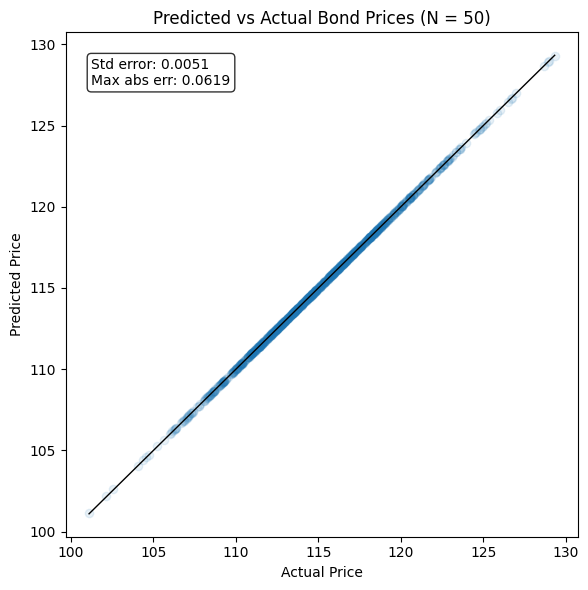

In [301]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Sample N = 50 scenarios ---
idx = np.random.choice(zero_scen.shape[0], 100, replace=False)
z_sub = zero_scen[idx]
p_sub = prices[idx]

# --- 2) Fit quadratic form on the 50-scenario subset ---
a, b, H = fit_quadratic_form(z_sub, p_sub)

# --- 3) Compute predictions ---
preds = a + np.sum((zero_scen @ H) * zero_scen, axis=1) + zero_scen.dot(b)

# --- 4) Compute error metrics ---
errors = preds - prices
std_err = np.std(errors)
max_abs_err = np.max(np.abs(errors))

# --- 5) Plot ---
plt.figure(figsize=(6,6))
plt.scatter(prices, preds, alpha=0.1)
plt.plot([prices.min(), prices.max()],
         [prices.min(), prices.max()],
         color='k', lw=1)       # 45° reference line
         # Annotate error metrics in the top-left
txt = f"Std error: {std_err:.4f}\nMax abs err: {max_abs_err:.4f}"
plt.text(0.05, 0.95, txt,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Bond Prices (N = 50)')
plt.tight_layout()
plt.show()

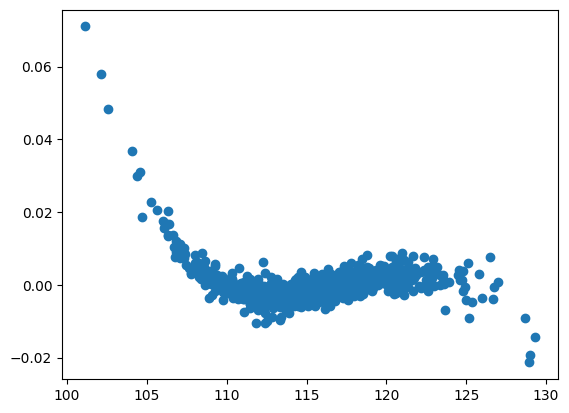

In [299]:
plt.scatter(prices, errors)

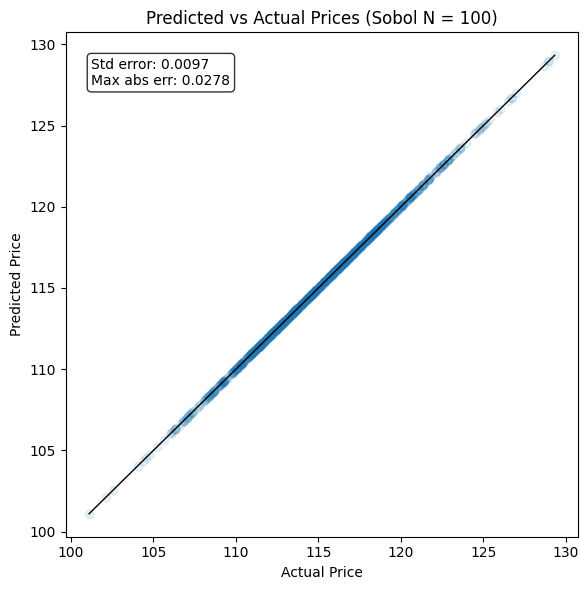

In [293]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc

# --- parameters ---
N_sobol = 100   # number of Sobol samples
M = zero_scen.shape[1]

# determine the hypercube bounds from your existing scenarios
z_min = zero_scen.min(axis=0)
z_max = zero_scen.max(axis=0)

# --- 1) Generate N_sobol points in [0,1]^M via Sobol ---
sampler = qmc.Sobol(d=M, scramble=True)
# SciPy’s Sobol needs n = 2^k, so overshoot and then take first N_sobol
k = int(np.ceil(np.log2(N_sobol)))
sobol01 = sampler.random_base2(m=k)[:N_sobol]

# scale into your zero‐curve hypercube
z_sub = qmc.scale(sobol01, z_min, z_max)   # shape (N_sobol, M)

# --- 2) Price each Sobol‐sampled curve to get prices p_sub ---
# assuming you have price_bond_via_spline(...) defined
# Example zero-curve pillars (in years) and scenarios
pillar_times = np.array([0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0])
base_rates   = np.array([0.015, 0.0175, 0.02, 0.021, 0.024, 0.025, 0.04])

np.random.seed(42)

p_sub = price_fixed_bond_scenarios(
      valuation_date=val_date,
      maturity_date=mat_date,
      coupon_rate=coupon,
      pillar_times=pillar_times,
      zero_rates_scenarios=z_sub,
      face_value=100.0,
      freq=freq
    )

# --- 3) Fit quadratic form on the Sobol sample ---
a, b, H = fit_quadratic_form(z_sub, p_sub)

# --- 4) Compute predictions on your full scenario set ---
preds = a + np.sum((zero_scen @ H) * zero_scen, axis=1) + zero_scen.dot(b)

# --- 5) Compute error metrics against the true prices array ---
errors     = preds - prices
std_err    = np.std(errors)
max_abs_err = np.max(np.abs(errors))

# --- 6) Plot Predicted vs Actual, with error annotations ---
plt.figure(figsize=(6,6))
plt.scatter(prices, preds, alpha=0.1)
plt.plot([prices.min(), prices.max()],
         [prices.min(), prices.max()],
         color='k', lw=1)  # 45° line

txt = f"Std error: {std_err:.4f}\nMax abs err: {max_abs_err:.4f}"
plt.text(0.05, 0.95, txt,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Predicted vs Actual Prices (Sobol N = {N_sobol})')
plt.tight_layout()
plt.show()

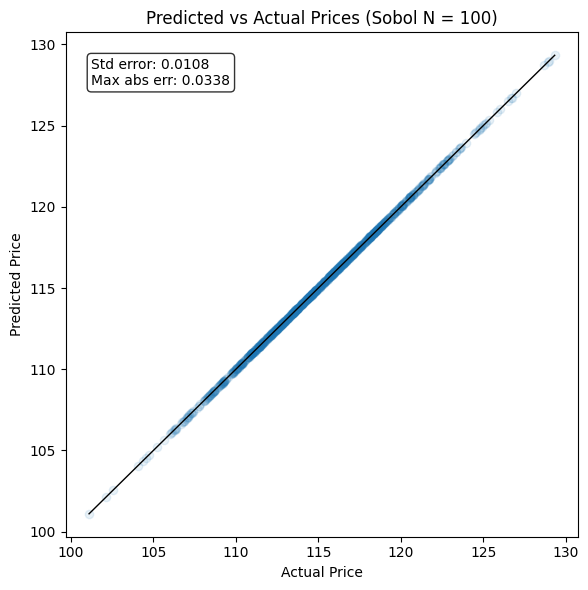

In [310]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc

# --- parameters ---
N_sobol = 100   # number of Sobol samples
M = zero_scen.shape[1]

# determine the hypercube bounds from your existing scenarios
z_min = zero_scen.min(axis=0)
z_max = zero_scen.max(axis=0)

# --- 1) Generate N_sobol points in [0,1]^M via Sobol ---
sampler = qmc.Sobol(d=M, scramble=True)
# SciPy’s Sobol needs n = 2^k, so overshoot and then take first N_sobol
k = int(np.ceil(np.log2(N_sobol)))
sobol01 = sampler.random_base2(m=k)[:N_sobol]

# scale into your zero‐curve hypercube
z_sub = qmc.scale(sobol01, z_min, z_max)   # shape (N_sobol, M)

# --- 2) Price each Sobol‐sampled curve to get prices p_sub ---
# assuming you have price_bond_via_spline(...) defined
# Example zero-curve pillars (in years) and scenarios
pillar_times = np.array([0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0])
base_rates   = np.array([0.015, 0.0175, 0.02, 0.021, 0.024, 0.025, 0.04])

np.random.seed(42)

p_sub = price_fixed_bond_scenarios(
      valuation_date=val_date,
      maturity_date=mat_date,
      coupon_rate=coupon,
      pillar_times=pillar_times,
      zero_rates_scenarios=z_sub,
      face_value=100.0,
      freq=freq
    )

# --- 3) Fit quadratic form on the Sobol sample ---
a, b, H = fit_quadratic_form(z_sub, p_sub)

# --- 3a) Compute the true DV01 at the central curve z0 ---
z0 = base_rates         # or explicitly your “base” zero curve
eps = 1e-4                        # 1bp bump
z_bump = z0 + eps

# surrogate PV at z0 (for reference – not strictly needed beyond sanity)
pv0 = a + b.dot(z0) + z0.dot(H).dot(z0)

p_bump = price_fixed_bond_scenarios(
  valuation_date=val_date,
  maturity_date=mat_date,
  coupon_rate=coupon,
  pillar_times=pillar_times,
  zero_rates_scenarios=z_bump.reshape(1,-1),
  face_value=100.0,
  freq=freq
)

# 4) Surrogate bumped PV
p_sur_bump = a + b.dot(z_bump) + z_bump.dot(H).dot(z_bump)

# 5) Adjust constant term
a += (p_bump - p_sur_bump)

# --- 4) Compute predictions on your full scenario set ---
preds = a + np.sum((zero_scen @ H) * zero_scen, axis=1) + zero_scen.dot(b)

# --- 5) Compute error metrics against the true prices array ---
errors     = preds - prices
std_err    = np.std(errors)
max_abs_err = np.max(np.abs(errors))

# --- 6) Plot Predicted vs Actual, with error annotations ---
plt.figure(figsize=(6,6))
plt.scatter(prices, preds, alpha=0.1)
plt.plot([prices.min(), prices.max()],
         [prices.min(), prices.max()],
         color='k', lw=1)  # 45° line

txt = f"Std error: {std_err:.4f}\nMax abs err: {max_abs_err:.4f}"
plt.text(0.05, 0.95, txt,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Predicted vs Actual Prices (Sobol N = {N_sobol})')
plt.tight_layout()
plt.show()

In [312]:
H.dot(z0)

array([ 0.20234055, -0.23524551,  0.22563212,  0.39583627,  0.80464583,
       33.84656197, 32.99277612])

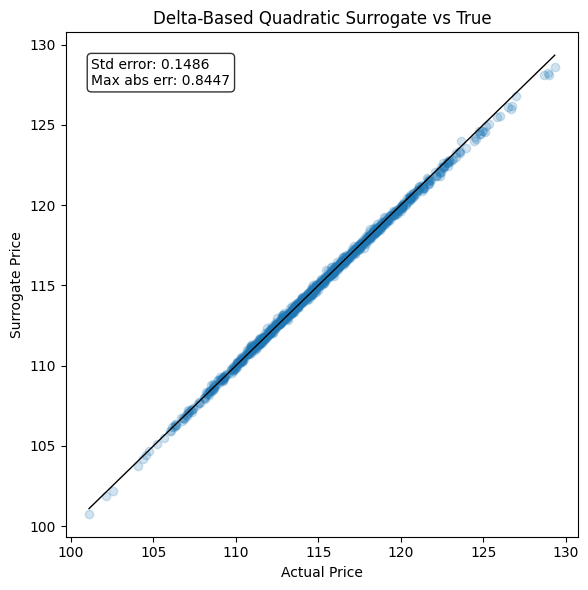

In [428]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc

# 0) Assume zero_scen, prices, pillar_times, val_date, mat_date, coupon, freq exist,
#    and price_fixed_bond_scenarios is defined.


# 1) Generate Sobol sample
N_sob = 25
M = zero_scen.shape[1]
z_min, z_max = zero_scen.min(0), zero_scen.max(0)
sampler = qmc.Sobol(d=M, scramble=False)
k = int(np.ceil(np.log2(N_sob)))
sobol01 = sampler.random_base2(m=k)[:N_sob]
z_sub = qmc.scale(sobol01, z_min, z_max)   # shape (N_sob, M)

# 2) True PVs on Sobol set
p_sub = price_fixed_bond_scenarios(
    valuation_date       = val_date,
    maturity_date        = mat_date,
    coupon_rate          = coupon,
    pillar_times         = pillar_times,
    zero_rates_scenarios = z_sub,
    face_value           = 100.0,
    freq                 = freq
)

# 3) Central PV
z0 = ((z_min+z_max)/2)[None, :]
P0 = price_fixed_bond_scenarios(
    valuation_date       = val_date,
    maturity_date        = mat_date,
    coupon_rate          = coupon,
    pillar_times         = pillar_times,
    zero_rates_scenarios = z0,
    face_value           = 100.0,
    freq                 = freq
)[0]

# 4) Build deltas
dz = z_sub - z0        # (N_sob, M)
dp = p_sub - P0        # (N_sob,)

# 5) Fit zero‐intercept quad ΔP ≈ b·Δz + ΔzᵀHΔz
def fit_delta_quadratic(dz, dp):
    N, M = dz.shape
    n_off = M*(M-1)//2
    p = M + M + n_off
    X = np.zeros((N, p))
    col = 0
    X[:, col:col+M] = dz; col += M
    X[:, col:col+M] = dz**2; col += M
    pairs = []
    for j in range(M):
        for k in range(j+1, M):
            X[:, col] = 2*dz[:, j]*dz[:, k]
            pairs.append((j, k))
            col += 1
    beta, *_ = np.linalg.lstsq(X, dp, rcond=None)
    b = beta[:M]
    diag = beta[M:2*M]
    off  = beta[2*M:]
    H = np.zeros((M, M))
    for j in range(M):
        H[j, j] = diag[j]
    for (j, k), c in zip(pairs, off):
        H[j, k] = H[k, j] = c
    return b, H

b_delta, H_delta = fit_delta_quadratic(dz, dp)

# 6) Define re‐based surrogate
def P_sur(z):
    dz_ = np.asarray(z) - z0.ravel()
    return P0 + b_delta.dot(dz_) + dz_.dot(H_delta).dot(dz_)

# 7) Evaluate and plot
pv_sur = np.array([P_sur(z) for z in zero_scen])

errors     = prices - pv_sur
std_err    = np.std(errors)
max_abs_err = np.max(np.abs(errors))

plt.figure(figsize=(6,6))
plt.scatter(prices, pv_sur, alpha=0.2)
plt.plot([prices.min(), prices.max()],
         [prices.min(), prices.max()],
         'k-', lw=1)

txt = f"Std error: {std_err:.4f}\nMax abs err: {max_abs_err:.4f}"
plt.text(0.05, 0.95, txt,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.xlabel('Actual Price')
plt.ylabel('Surrogate Price')
plt.title('Delta-Based Quadratic Surrogate vs True')
plt.tight_layout()
plt.show()

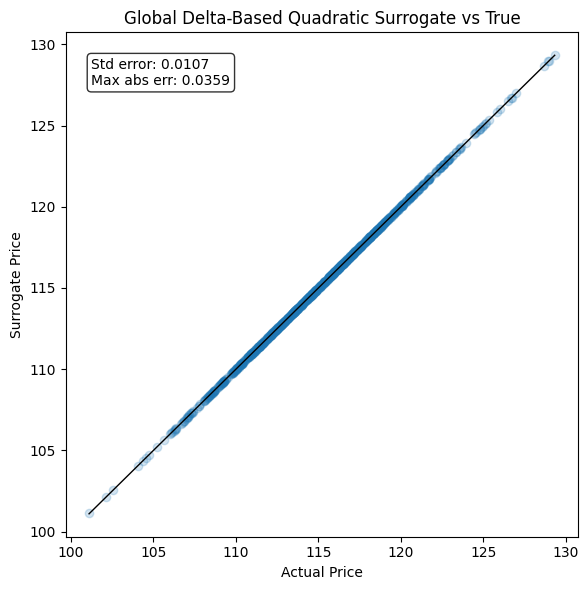

In [460]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from sklearn.decomposition import PCA

# 0) Assume zero_scen, prices, pillar_times, val_date, mat_date, coupon, freq exist,
#    and price_fixed_bond_scenarios is defined.

# 1) Fit PCA on your full-scenario zero-rate matrix
#    zero_scen: array shape (N_scen, M)
pca = PCA()
scores = pca.fit_transform(zero_scen)   # shape (N_scen, M)

# 2) Determine hypercube bounds in PCA‐score space
score_min = scores.min(axis=0)          # length M
score_max = scores.max(axis=0)          # length M

# 3) Sample N_sob points in [0,1]^M via Sobol
N_sob = 78
d = scores.shape[1]                     # = M
sampler = qmc.Sobol(d=d, scramble=False)
k = int(np.ceil(np.log2(N_sob)))
sobol01 = sampler.random_base2(m=k)[:N_sob]  # shape (N_sob, M)

# 4) Scale those into your PCA hypercube [score_min, score_max]
scores_sub = qmc.scale(sobol01, score_min, score_max)  # shape (N_sob, M)

# 5) Inverse‐transform back to zero‐rate space
z_sub = pca.inverse_transform(scores_sub)  # shape (N_sob, M)

# 2) True PVs on Sobol set
p_sub = price_fixed_bond_scenarios(
    valuation_date       = val_date,
    maturity_date        = mat_date,
    coupon_rate          = coupon,
    pillar_times         = pillar_times,
    zero_rates_scenarios = z_sub,
    face_value           = 100.0,
    freq                 = freq
)

# 3) Central PV
z0 = ((z_min+z_max)/2)[None, :]
P0 = price_fixed_bond_scenarios(
    valuation_date       = val_date,
    maturity_date        = mat_date,
    coupon_rate          = coupon,
    pillar_times         = pillar_times,
    zero_rates_scenarios = z0,
    face_value           = 100.0,
    freq                 = freq
)[0]

# 4) Build deltas
dz = z_sub - z0        # (N_sob, M)
dp = p_sub - P0        # (N_sob,)

# 5) Fit zero‐intercept quad ΔP ≈ b·Δz + ΔzᵀHΔz
def fit_delta_quadratic(dz, dp):
    N, M = dz.shape
    n_off = M*(M-1)//2
    p = M + M + n_off
    X = np.zeros((N, p))
    col = 0
    X[:, col:col+M] = dz; col += M
    X[:, col:col+M] = dz**2; col += M
    pairs = []
    for j in range(M):
        for k in range(j+1, M):
            X[:, col] = 2*dz[:, j]*dz[:, k]
            pairs.append((j, k))
            col += 1
    beta, *_ = np.linalg.lstsq(X, dp, rcond=None)
    b = beta[:M]
    diag = beta[M:2*M]
    off  = beta[2*M:]
    H = np.zeros((M, M))
    for j in range(M):
        H[j, j] = diag[j]
    for (j, k), c in zip(pairs, off):
        H[j, k] = H[k, j] = c
    return b, H

b_delta, H_delta = fit_delta_quadratic(dz, dp)

# 6) Define re‐based surrogate
def P_sur(z):
    dz_ = np.asarray(z) - z0.ravel()
    return P0 + b_delta.dot(dz_) + dz_.dot(H_delta).dot(dz_)

# 7) Evaluate and plot
pv_sur = np.array([P_sur(z) for z in zero_scen])

errors     = prices - pv_sur
std_err    = np.std(errors)
max_abs_err = np.max(np.abs(errors))

plt.figure(figsize=(6,6))
plt.scatter(prices, pv_sur, alpha=0.2)
plt.plot([prices.min(), prices.max()],
         [prices.min(), prices.max()],
         'k-', lw=1)

txt = f"Std error: {std_err:.4f}\nMax abs err: {max_abs_err:.4f}"
plt.text(0.05, 0.95, txt,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.xlabel('Actual Price')
plt.ylabel('Surrogate Price')
plt.title('Global Delta-Based Quadratic Surrogate vs True')
plt.tight_layout()
plt.show()

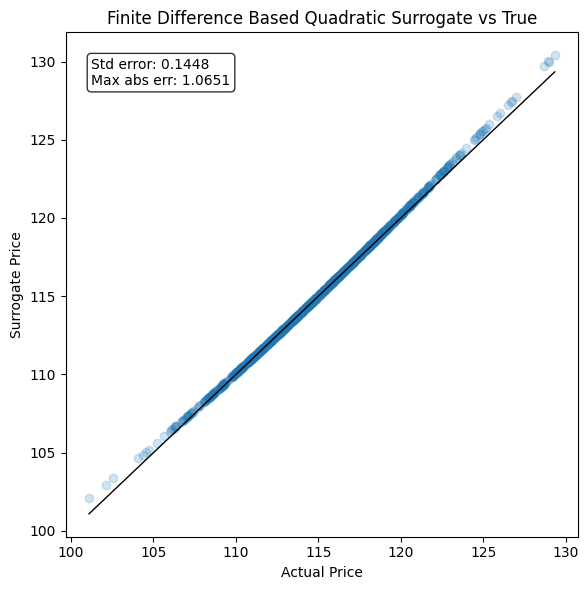

In [459]:
import numpy as np

# --- assume price_fixed_bond_scenarios and all inputs are defined ---
# zero_scen         : full-scenario array, shape (N_scen, M)
# pillar_times, val_date, mat_date, coupon, freq, face_value, etc.

# 1) pick central curve z0 (e.g. midpoint of your hypercube or market curve)
z_min, z_max = zero_scen.min(0), zero_scen.max(0)
z0 = (z_min + z_max) / 2.0            # shape (M,)
M = z0.size

# 2) price at the center
p0 = price_fixed_bond_scenarios(
    valuation_date       = val_date,
    maturity_date        = mat_date,
    coupon_rate          = coupon,
    pillar_times         = pillar_times,
    zero_rates_scenarios = z0[None, :],   # make it (1, M)
    face_value           = 100.0,
    freq                 = freq
)[0]

# 3) set bump size
h = 1e-4  # 1bp

# allocate gradient and Hessian
b_delta = np.zeros(M)
H_delta = np.zeros((M, M))

# 4) first and second partials
for j in range(M):
    # bump up/down pillar j
    z_up   = z0.copy(); z_up[j] += h
    z_down = z0.copy(); z_down[j] -= h

    p_up   = price_fixed_bond_scenarios(
        valuation_date       = val_date,
        maturity_date        = mat_date,
        coupon_rate          = coupon,
        pillar_times         = pillar_times,
        zero_rates_scenarios = z_up[None, :],
        face_value           = 100.0,
        freq                 = freq
    )[0]

    p_down = price_fixed_bond_scenarios(
        valuation_date       = val_date,
        maturity_date        = mat_date,
        coupon_rate          = coupon,
        pillar_times         = pillar_times,
        zero_rates_scenarios = z_down[None, :],
        face_value           = 100.0,
        freq                 = freq
    )[0]

    # central diff for gradient
    b_delta[j] = (p_up - p_down) / (2*h)

    # second derivative on diagonal
    H_delta[j, j] = (p_up - 2*p0 + p_down) / (h*h)

# 5) mixed partials
for j in range(M):
    for k in range(j+1, M):
        # bump both j and k
        z_ujuk = z0.copy()
        z_ujuk[j] += h
        z_ujuk[k] += h

        # bump j only
        z_uj   = z0.copy(); z_uj[j] += h
        # bump k only
        z_uk   = z0.copy(); z_uk[k] += h

        p_ujuk = price_fixed_bond_scenarios(
            valuation_date       = val_date,
            maturity_date        = mat_date,
            coupon_rate          = coupon,
            pillar_times         = pillar_times,
            zero_rates_scenarios = z_ujuk[None, :],
            face_value           = 100.0,
            freq                 = freq
        )[0]
        p_uj = price_fixed_bond_scenarios(
            valuation_date       = val_date,
            maturity_date        = mat_date,
            coupon_rate          = coupon,
            pillar_times         = pillar_times,
            zero_rates_scenarios = z_uj[None, :],
            face_value           = 100.0,
            freq                 = freq
        )[0]
        p_uk = price_fixed_bond_scenarios(
            valuation_date       = val_date,
            maturity_date        = mat_date,
            coupon_rate          = coupon,
            pillar_times         = pillar_times,
            zero_rates_scenarios = z_uk[None, :],
            face_value           = 100.0,
            freq                 = freq
        )[0]

        # mixed second derivative
        H_delta[j, k] = H_delta[k, j] = (
            p_ujuk
            - p_uj
            - p_uk
            + p0
        ) / (h*h)

# Now b_delta holds ∂P/∂z at z0, and H_delta the full Hessian ∂²P/∂z².


# 6) Define re‐based surrogate
def P_sur(z):
    dz_ = np.asarray(z) - z0.ravel()
    return P0 + b_delta.dot(dz_) + dz_.dot(H_delta).dot(dz_)

# 7) Evaluate and plot
pv_sur = np.array([P_sur(z) for z in zero_scen])

errors     = prices - pv_sur
std_err    = np.std(errors)
max_abs_err = np.max(np.abs(errors))

plt.figure(figsize=(6,6))
plt.scatter(prices, pv_sur, alpha=0.2)
plt.plot([prices.min(), prices.max()],
         [prices.min(), prices.max()],
         'k-', lw=1)

txt = f"Std error: {std_err:.4f}\nMax abs err: {max_abs_err:.4f}"
plt.text(0.05, 0.95, txt,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.xlabel('Actual Price')
plt.ylabel('Surrogate Price')
plt.title('Finite Difference Based Quadratic Surrogate vs True')
plt.tight_layout()
plt.show()